# Setup

**Download deepdrive_course repository when running in Google Colab (to have access to libraries)**

In [ ]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  !git clone https://github.com/abojda/deepdrive_course.git dd_course
  !pip install dd_course/ -q

In [3]:
!python3 -m pip install pytorch-lightning timm opencv-python gdown patool mega.py -q

**Install Captum from source, since fix for https://github.com/pytorch/captum/issues/1136 was not yet released (2.07.2023)**

In [ ]:
import os

if not os.path.isdir('captum'):
  !git clone https://github.com/pytorch/captum.git

!pip install captum/ -q

In [5]:
import torch
import pytorch_lightning as pl

# Model

## Download model weigths

In [6]:
from deepdrive_course.utils import download_from_mega_nz

# resnet50-tl-ft_onecycle_lr0.0005-drop_0.3-basic_aug---val_loss=0.15.ckpt
checkpoint = download_from_mega_nz('https://mega.nz/file/1mkigBqC#N3wyKt1N15DydkYNoniQvkcLqYCbPMDohvHY7UsVAGw')

## Load model

In [7]:
from deepdrive_course.resisc45.modules import ResiscLit

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResiscLit.load_from_checkpoint(checkpoint, map_location=device)

# Run test

In [ ]:
from deepdrive_course.resisc45.datamodules import RESISC45DataModule
from deepdrive_course.resisc45.transforms import get_transform

batch_size = 64
train_transform = get_transform('albumentations_imagenet_norm')
test_transform = get_transform('albumentations_imagenet_norm')
alb = True

datamodule = RESISC45DataModule(root='data',
                                batch_size=batch_size,
                                train_transform=train_transform,
                                test_transform=test_transform,
                                albumentations=alb)

trainer = pl.Trainer()
metrics = trainer.test(model, datamodule=datamodule)

In [35]:
print(metrics)

[{'test_loss': 0.15354874730110168, 'test_acc': 0.9638095498085022, 'test_f1_score': 0.9638095498085022}]


# Analysis of properly classified and misclassified images

## Interpretation functions

In [9]:
from deepdrive_course.interpret import gradcam_analysis, guided_gradcam_analysis, occlusion_analysis
from deepdrive_course.utils import plot_to_pil_image
from deepdrive_course.resisc45.datasets import RESISC45

import matplotlib.pyplot as plt
from PIL import Image

def pil_stack_images_vertically(images):
    """
    Assumes that images have the same size!
    """
    w, h = images[0].width, images[0].height
    new_h = len(images) * h
    new_img = Image.new('RGB', (w, new_h))

    for i, img in enumerate(images):
      new_img.paste(img, (0, i * h))

    return new_img

def interpret_gradcam(model, img, pred_label, true_label, probas, last_layer):
    interpret_imgs = []

    true_class = RESISC45.classes[true_label]
    pred_class = RESISC45.classes[pred_label]
    pred_class_prob = probas[pred_label]
    true_class_prob = probas[true_label]

    # GradCAM for PREDICTED class
    fig, ax = gradcam_analysis(img, pred_label, model, last_layer)
    fig.suptitle(f'[GradCAM] Predicted class: ({pred_class}) [{pred_class_prob:.1%}]')
    interpret_imgs.append(plot_to_pil_image(fig))

    # GradCAM for TRUE class - display only if different than predicted class
    if true_label != pred_label:
      fig, ax = gradcam_analysis(img, true_label, model, last_layer)
      fig.suptitle(f'[GradCAM] True class: ({true_class}) [{true_class_prob:.1%}]')
      interpret_imgs.append(plot_to_pil_image(fig))

    # Guided GradCAM for PREDICTED class
    fig, ax = guided_gradcam_analysis(img, pred_label, model, last_layer)
    fig.suptitle(f'[Guided GradCAM] Predicted class: ({pred_class}) [{pred_class_prob:.1%}]')
    interpret_imgs.append(plot_to_pil_image(fig))

    # Guided GradCAM for TRUE class - display only if different than predicted class
    if true_label != pred_label:
      fig, ax = guided_gradcam_analysis(img, true_label, model, last_layer)
      fig.suptitle(f'[Guided GradCAM] True class: ({true_class}) [{true_class_prob:.1%}]')
      interpret_imgs.append(plot_to_pil_image(fig))

    return pil_stack_images_vertically(interpret_imgs)


def interpret_occlusion(model, img, pred_label, true_label, probas, window, strides):
    interpret_imgs = []

    true_class = RESISC45.classes[true_label]
    pred_class = RESISC45.classes[pred_label]
    pred_class_prob = probas[pred_label]
    true_class_prob = probas[true_label]

    # Occlusion for PREDICTED class
    fig, ax = occlusion_analysis(img, pred_label, model, window, strides)
    fig.suptitle(f'[Occlusion] Predicted class: ({pred_class}) [{pred_class_prob:.1%}]')
    interpret_imgs.append(plot_to_pil_image(fig))

    # # Occlusion for TRUE class - display only if different than predicted class
    if true_label != pred_label:
      fig, ax = occlusion_analysis(img, true_label, model, window, strides)
      fig.suptitle(f'[Occlusion] True class: ({true_class}) [{true_class_prob:.1%}]')
      interpret_imgs.append(plot_to_pil_image(fig))

    return pil_stack_images_vertically(interpret_imgs)

## Create examples generator
(With optional pred/true class filtering)

In [10]:
def get_examples_gen(examples, pred_class=None, true_class=None):
  if pred_class:
    pred_label = RESISC45.class_to_idx[pred_class]
    pred_label_filter = lambda label: label == pred_label
  else:
    pred_label_filter = lambda label: True

  if true_class:
    true_label = RESISC45.class_to_idx[true_class]
    true_label_filter = lambda label: label == true_label
  else:
    true_label_filter = lambda label: True

  examples = [(img, pred_label, true_label, probas) for img, pred_label, true_label, probas in examples
                 if pred_label_filter(pred_label) and true_label_filter(true_label)]

  print(f'{len(examples)} images matching criteria')
  return (sample for sample in examples)

## Select generator

In [25]:
# PROPERLY CLASSIFIED
# examples_gen = get_examples_gen(model.test_properly_classified)
# examples_gen = get_examples_gen(model.test_properly_classified, pred_class='church')

# MISCLASSIFIED
examples_gen = get_examples_gen(model.test_misclassified)
# examples_gen = get_examples_gen(model.test_misclassified, pred_class='church')
# examples_gen = get_examples_gen(model.test_misclassified, true_class='intersection')
# examples_gen = get_examples_gen(model.test_misclassified, pred_class='intersection', true_class='roundabout')

228 images matching criteria


## Run analysis on a single image
Since we use generators, we can re-run below cell multiple times to analyse different images

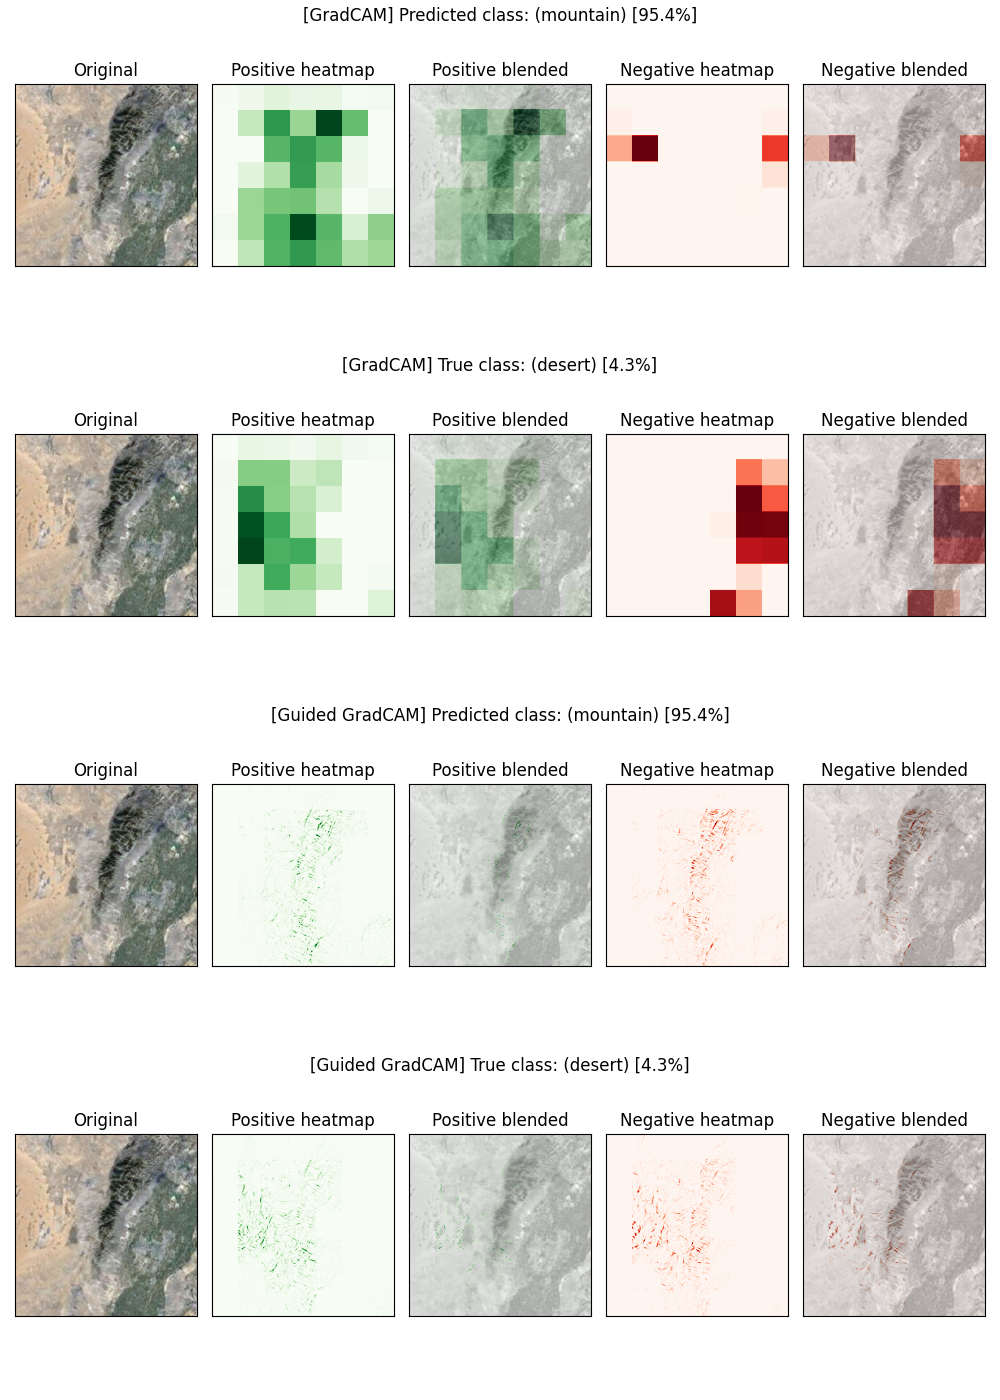

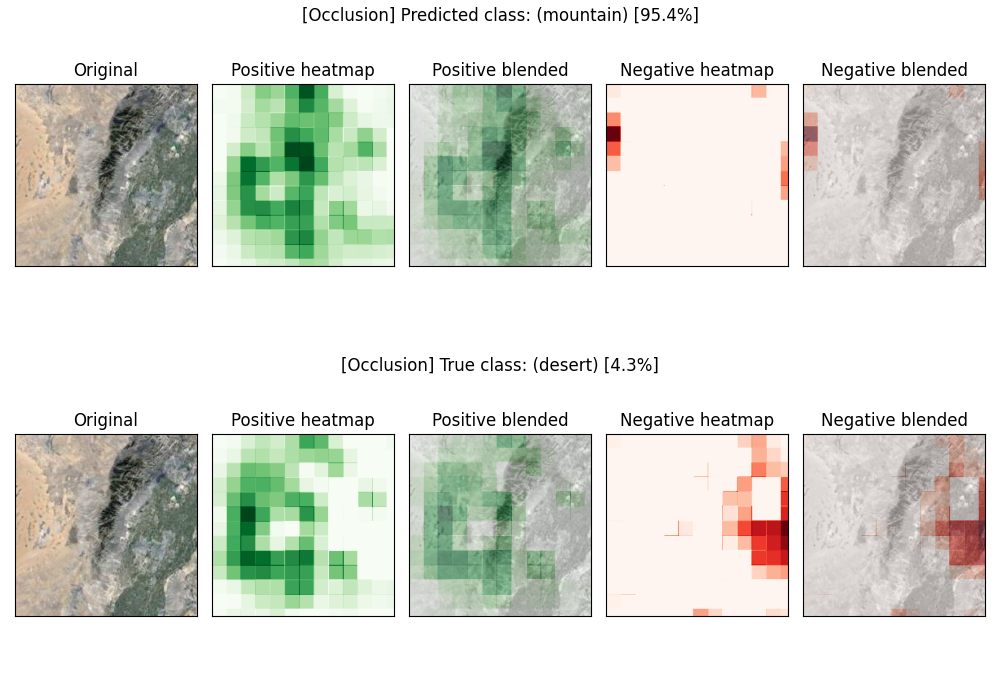

In [34]:
if model.training:
    model.eval()

# Layer used for attribution analysis
last_layer = model.model.layer4[-1]

# Get next prediction
img, pred_label, true_label, probas = next(examples_gen)

# Run and display interpretation (GradCam and/or occlussion sensitivity)
display(interpret_gradcam(model, img, pred_label, true_label, probas, last_layer))
display(interpret_occlusion(model, img, pred_label, true_label, probas, window=(3,35,35), strides=(3,18,18)))